<a id=top-page></a>

# Integrate `pykitPIV` with `LIMA`

<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size="3"><strong>Table of contents:</strong></font>
<br>
<ol>
    <li><a href="#synthetic-images">Generate synthetic images with pykitPIV</a></li>
    <li><a href="#train-LIMA">Train LIMA with the generated images</a></li>
</ol>
<p></p>
</div>
<br>





***

In [21]:
import argparse
import os
import pytorch_lightning as pl
import torchvision.transforms
from rich import print
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import cmcrameri.cm as cmc
import lima
from pykitPIV import Particle, FlowField, Motion, Image

<a id=synthetic-images></a>

***

## Generate synthetic images with `pykitPIV`

[Go to the top](#top-page)

In [22]:
image_size = (140,200)

In [23]:
size_buffer = 10

In [24]:
figsize = (5,4)

<a id=synthetic-images-training-set></a>

### Training set

[Go to the top](#top-page)

In [25]:
n_images = 10

In [26]:
particles = Particle(n_images, 
                     size=image_size, 
                     size_buffer=size_buffer,
                     diameters=(4,4.1),
                     distances=(1,2),
                     densities=(0.05,0.1),
                     signal_to_noise=(5,20),
                     diameter_std=0.2,
                     seeding_mode='random', 
                     random_seed=100)

In [27]:
image = Image(random_seed=100)

In [28]:
image.add_particles(particles)

Particles added to the image.


In [29]:
image.add_reflected_light(exposures=(0.6,0.65),
                          maximum_intensity=2**16-1,
                          laser_beam_thickness=1,
                          laser_over_exposure=1,
                          laser_beam_shape=0.95,
                          alpha=1/10)

Reflected light added to images I1.


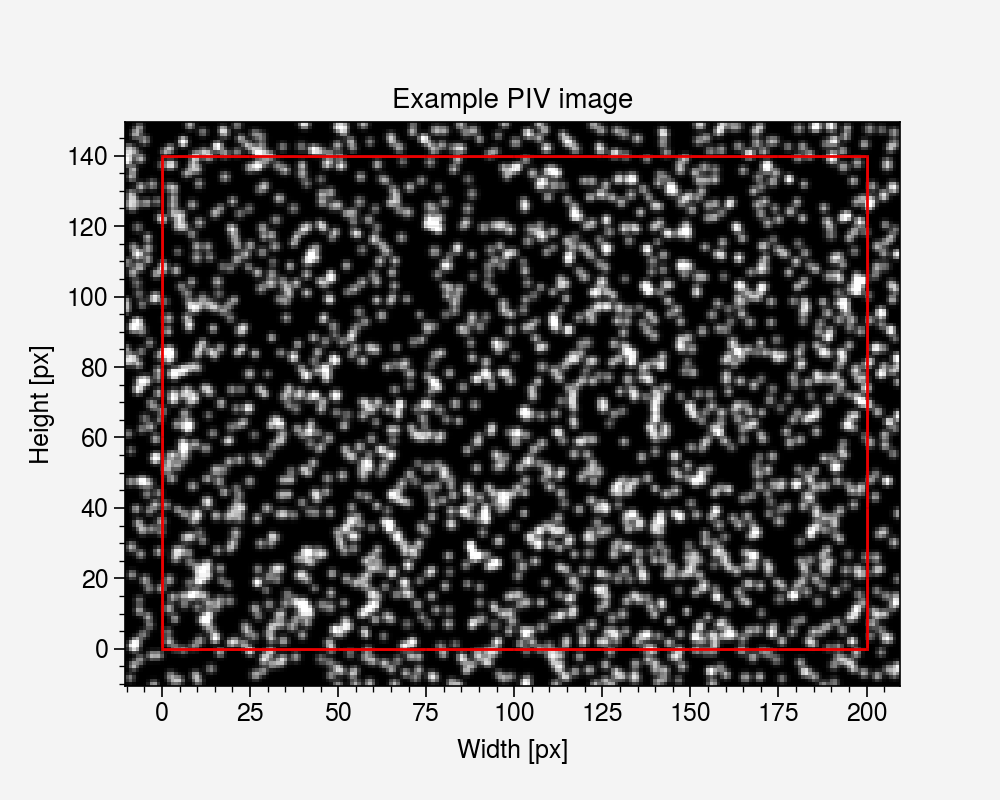

In [30]:
image.plot(0, 
           with_buffer=True,
           xlabel='Width [px]',
           ylabel='Height [px]',
           title='Example PIV image',
           cmap='Greys_r',
           figsize=figsize, 
           filename='example-image.png');

In [31]:
flowfield = FlowField(n_images,
                      size=image_size,
                      size_buffer=size_buffer,
                      flow_mode='random',
                      gaussian_filters=(10,11),
                      n_gaussian_filter_iter=20,
                      sin_period=(30,300),
                      displacement=(0,10),
                      random_seed=100)

In [32]:
image.add_velocity_field(flowfield)

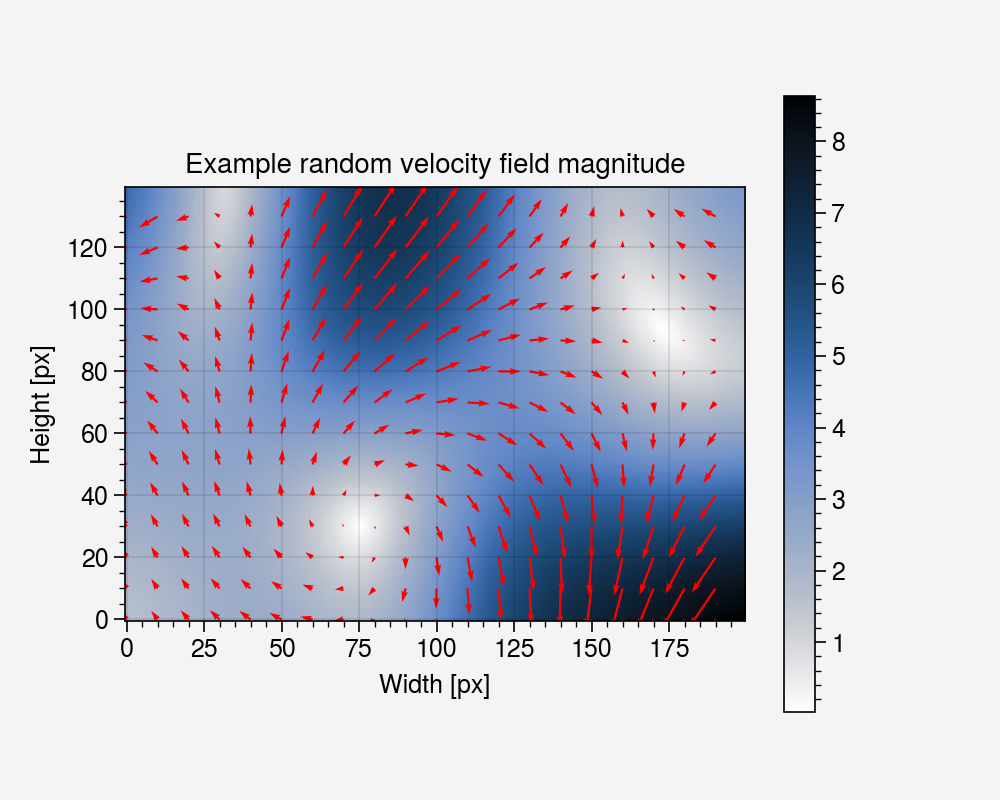

In [33]:
image.plot_velocity_field_magnitude(0,
                                    with_buffer=False,
                                    add_quiver=True,
                                    quiver_step=10,
                                    quiver_color='r',
                                    xlabel='Width [px]',
                                    ylabel='Height [px]',
                                    title='Example random velocity field magnitude',
                                    cmap=cmc.oslo_r,
                                    figsize=figsize,
                                    filename='example-random-velocity-field-magnitude-quiver.png');

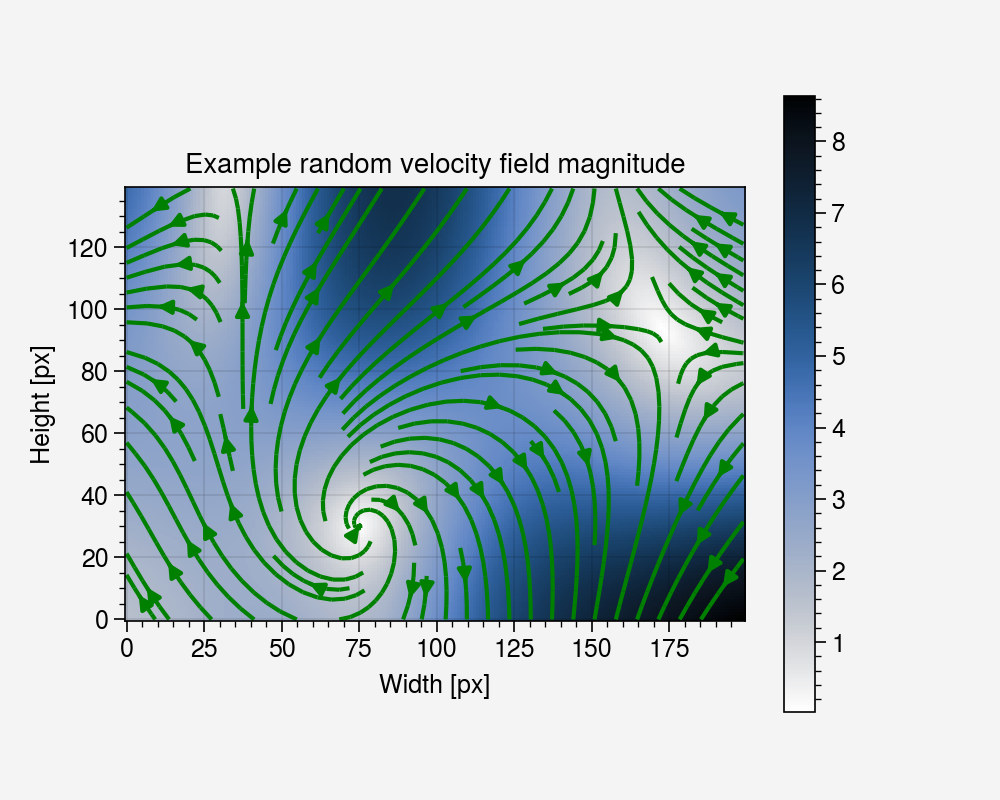

In [34]:
image.plot_velocity_field_magnitude(0,
                                    with_buffer=False,
                                    add_streamplot=True,
                                    streamplot_density=1,
                                    streamplot_color='g',
                                    xlabel='Width [px]',
                                    ylabel='Height [px]',
                                    title='Example random velocity field magnitude',
                                    cmap=cmc.oslo_r,
                                    figsize=figsize,
                                    filename='example-random-velocity-field-magnitude-streamplot.png');

In [35]:
motion = Motion(particles, 
                flowfield, 
                time_separation=0.1)

In [36]:
motion.forward_euler(n_steps=10)

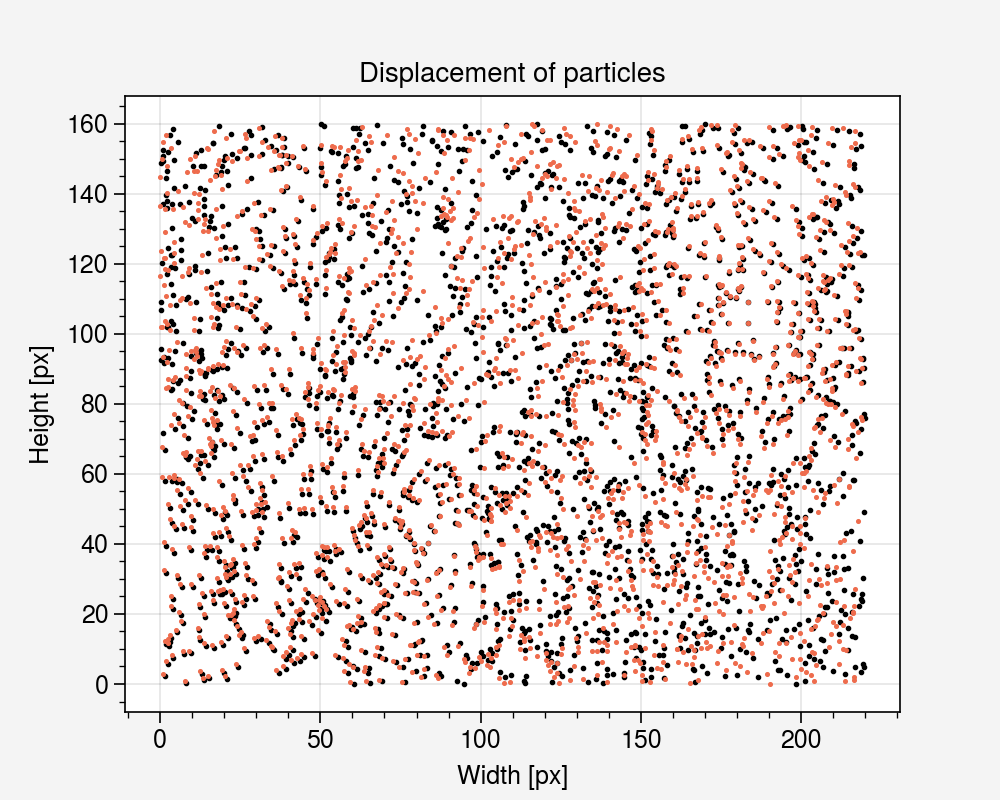

In [37]:
motion.plot_particle_motion(0,
                            xlabel='Width [px]',
                            ylabel='Height [px]',
                            title='Displacement of particles',
                            figsize=figsize,
                            filename='particle-displacement-01.png');

In [38]:
image.add_motion(motion)

In [39]:
image.add_reflected_light(exposures=(0.01,0.8),
                          maximum_intensity=2**16-1,
                          laser_beam_thickness=1,
                          laser_over_exposure=1,
                          laser_beam_shape=0.95,
                          alpha=1/10)

Reflected light added to images I1.
Reflected light added to images I2.


<a id=synthetic-images-testing-set></a>

### Testing set

[Go to the top](#top-page)

<a id=train-LIMA></a>
***

## Train `LIMA` with the generated images

[Go to the top](#top-page)

In [ ]:
def get_train_test_loader(args):
    # Data loader
    transform = torchvision.transforms.Compose(
        [
            lima.transforms.RandomAffine(
                degrees=17, translate=(0.2, 0.2), scale=(0.9, 2.0)
            ),
            lima.transforms.RandomHorizontalFlip(),
            lima.transforms.RandomVerticalFlip(),
            lima.transforms.ToTensor(),
            lima.transforms.NormalizeBounded(
                bit_depth=8 if args.dataset == "num" else 16
            ),
            lima.transforms.RandomBrightness(factor=(0.5, 2)),
            lima.transforms.RandomNoise(std=(0, args.noise_std)),
        ]
    )

    datasets_path = {
        "rand_L_lag": (
            "../data/random_256px_train_n18278_lagrangian.mat",
            "../data/random_256px_test_n18278_lagrangian.mat",
        ),
    }

    args.train_dataset = datasets_path[args.dataset][0]
    args.test_dataset = datasets_path[args.dataset][1]

    if args.dataset in ["rand_L_lag", "rand_VL_lag"]:
        train_dataset = lima.dataset.MATLABDataset(
            path=args.train_dataset,
            transform=transform,
        )
        test_dataset = lima.dataset.MATLABDataset(
            path=args.test_dataset,
            transform=transform,
        )
    else:
        train_dataset = lima.dataset.HDF5Dataset(
            path=args.train_dataset,
            transform=transform,
        )
        test_dataset = lima.dataset.HDF5Dataset(
            path=args.test_dataset,
            transform=transform,
        )

    train_loader = DataLoader(
        train_dataset,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=args.num_workers,
        pin_memory=True,
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=args.batch_size,
    )

    return train_loader, test_loader

In [ ]:
# 1. Log
dict_args = vars(args)
print(dict_args)

pl.seed_everything(args.seed, workers=True)

# 2. Setup train/test dataset
train_loader, test_loader = get_train_test_loader(args)
args.len_train_loader = len(train_loader)

# 3. Define the model
model = lima.LIMA(**dict_args)

# 4. Define logger
logger = pl.loggers.WandbLogger(
    project=args.project,
    entity="empa305",
    name=args.run,
    save_dir=os.path.join(os.path.dirname(__file__), "logs"),
    log_model=True,
)
logger.watch(model, log="all")

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="val_loss",
    save_top_k=1,
)

# 5. Setup trainer
trainer = pl.Trainer.from_argparse_args(
    args,
    accelerator=None if args.num_nodes == 1 else "ddp",
    gpus=1,
    logger=logger,
    max_epochs=args.epochs,
    callbacks=[checkpoint_callback, pl.callbacks.RichProgressBar()],
)

# 6. Train the model
trainer.fit(model, train_loader, test_loader)


***